# DTCNS package and its quick start in Generation 1

**Generation 1 (G1)** of DT-CNSs models dynamic process on static networks. **DTCNS** package can generate DT-CNSs in **G1** based on five modules, including **Feature**, **SocialDNA**, **Network**, **EpiCondition** and **Process**. 

+ **Feature** module enables the crisp representation of specific numerical features and the fuzzy representation of uncertain numerical features. 

+ **SocialDNA** module reserves the node's preferences for features and feature differences. 

+ **Network** module can generate social networks based on features and preferences. 

+ **EpiCondition** module calculates the nodes' adoptability (liability) to the spread (e.g. epidemic spread). 

+ **Process** module simulates the dynamic process that starts from a seed node given a specific transmissibility.

**In this document, we use a toy example to illustrate the functionalities of each module. Assuming five nodes who interact based on the preference for connecting with others ......**

In [1]:
from DTCNS.Network import Network,SocialDNA
from DTCNS.Feature import Feature
from DTCNS.Process import Process
import pandas as pd
import numpy as np

# A. Feature Representation

We assume five nodes who interact based on the preference for connecting with others. These nodes consider the features of other nodes and the feature differences with other nodes. For example, we simulate two features for these nodes, including age and sex.

In [2]:
AgeSexData = pd.DataFrame(columns = ["Age","Sex"])
AgeSexData["Sex"] = [0,1,1,0,1] # 1 and 0 each represents males and females.
AgeSexData["Age"] = [15,21,36,51,63]
AgeSexData

,Age,Sex
0,15,0
1,21,1
2,36,1
3,51,0
4,63,1


### A1. Crisp Representation of Age and Sex

When the nodes can observe the age and sex features and know the specific feature values, we can represent the features based on crisp representation principles. 

+ **Feature.CrispRepresentation( )** standardises the numerical feature values into the range [0,1] and stores the crisp representation of features (stored in **Feature.feature**) and feature differences (stored in **Feature.featureDifferenceDict**). 

In [3]:
AgeSexFeatures = Feature(AgeSexData)
AgeSexFeatures.CrispRepresentation()

The nodes are denoted as 0, 1, 2, 3, 4 and reserved in a list.

In [4]:
AgeSexFeatures.nodes

[0, 1, 2, 3, 4]

In [5]:
AgeSexFeatures.feature

,Age,Sex
0,0.0000,0.0
1,0.1250,1.0
2,0.4375,1.0
3,0.7500,0.0
4,1.0000,1.0


In the feature difference dictionary, we can find the feature differences between any focal node (e.g. node denoted as 3) and other nodes.

In [6]:
AgeSexFeatures.featureDifferenceDict[3]

,Age Difference,Sex Difference
0,0.7500,0.0
1,0.6250,1.0
2,0.3125,1.0
3,0.0000,0.0
4,0.2500,1.0


### A2. Fuzzy Representation of Age

When the nodes are uncertain about the age and the age difference, we can represent the age feature based on fuzzy representation principles. 

+ **Feature.FuzzyRepresentation( )** unfolds a single numerical feature (feature difference) into a series of membership values that range between [0,1]. This function builds fuzzy sets for the feature and the feature difference based on Gaussian Membership functions. It requires initialising the number of fuzzy sets and the corresponding Gaussian Membership functions.

In [7]:
AgeData = pd.DataFrame(columns=["Age"])
AgeData["Age"] = [15,21,36,51,63]

We initialise three fuzzy sets to represent the age feature, each focusing on the ages around 15, 30 and 60. The sigma values control the spread of fuzzy sets and are set as 5, which, based on the Gaussian Membership function, generally capture the age characteristics around the ranges of [12-3 * 5,12+3 * 5], [35-3 * 5,35+3 * 5] and [60-3 * 5,60+3 * 5].

In [8]:
NumFuzzyPdict = {"Age":3}
FuzzyPparams = pd.DataFrame(columns=["mu","sigma"])
FuzzyPparams["mu"] = [15,30,60]
FuzzyPparams["sigma"] =[5,5,5]
FuzzyPparamsDict = {"Age":FuzzyPparams}

FuzzyPparamsDict

{'Age':    mu  sigma
 0  15      5
 1  30      5
 2  60      5}

Similarly, we initialise four fuzzy sets to represent the age differences around 0 and 12.

In [9]:
NumFuzzyHdict = {"Age":2}
FuzzyHparams = pd.DataFrame(columns=["mu","sigma"])
FuzzyHparams["mu"] = [0,12]
FuzzyHparams["sigma"] =[5,5]
FuzzyHparamsDict = {"Age":FuzzyHparams}

FuzzyHparamsDict

{'Age':    mu  sigma
 0   0      5
 1  12      5}

We can represent uncertain age features and age differences based on the set-ups of fuzzy sets.

In [10]:
AgeFeatures = Feature(AgeData)
AgeFeatures.FuzzyRepresentation(
    NumFuzzyPdict = NumFuzzyPdict,
    NumFuzzyHdict = NumFuzzyHdict,
    minValue = {"Age":0},# default: minimum feature values.
    maxValue = {"Age":70}, #default: maximum feature values.
    minDiffValue = {"Age":0}, # default: minimum feature differences with the focal node and others
    maxDiffValue = {"Age":70},# default: maximum feature differences with the focal node and others
    FuzzyPparamsDict = FuzzyPparamsDict,#default:mu values evenly split feature value range; sigma value is 5.
    FuzzyHparamsDict = FuzzyHparamsDict#default:mu values evenly split feature difference range; sigma value is 5.
                    )

The age feature is unfolded into three features, which indicate the memberships of an age value for the corresponding fuzzy set.

In [11]:
AgeFeatures.feature

,Age-Fuzzy0,Age-Fuzzy1,Age-Fuzzy2
0,1.000000e+00,1.110900e-02,2.576757e-18
1,4.867523e-01,1.978987e-01,6.148396e-14
2,1.477484e-04,4.867523e-01,9.929504e-06
3,5.534610e-12,1.477484e-04,1.978987e-01
4,9.720985e-21,3.475891e-10,8.352702e-01


Similarly, the age difference between the nodes can be unfolded into two membership values.

In [12]:
AgeFeatures.featureDifferenceDict[3]

,Age Difference-Fuzzy0,Age Difference-Fuzzy1
0,5.534610e-12,0.000010
1,1.522998e-08,0.001534
2,1.110900e-02,0.835270
3,1.000000e+00,0.056135
4,5.613476e-02,1.000000


### A3.Feature Update

We replace the previous crisp representation of age in age and sex feature representations with the fuzzy representation of age. 

+ **Feature.FeatureUpdate( )** function updates a feature object with new features.

In [13]:
AgeSexFeatures.FeatureUpdate(AgeFeatures,ReplaceFeatures=["Age"])

In [14]:
AgeSexFeatures.feature

,Sex,Age-Fuzzy0,Age-Fuzzy1,Age-Fuzzy2
0,0.0,1.000000e+00,1.110900e-02,2.576757e-18
1,1.0,4.867523e-01,1.978987e-01,6.148396e-14
2,1.0,1.477484e-04,4.867523e-01,9.929504e-06
3,0.0,5.534610e-12,1.477484e-04,1.978987e-01
4,1.0,9.720985e-21,3.475891e-10,8.352702e-01


In [15]:
AgeSexFeatures.featureDifferenceDict[2]

,Sex Difference,Age Difference-Fuzzy0,Age Difference-Fuzzy1
0,1.0,1.477484e-04,0.197899
1,0.0,1.110900e-02,0.835270
2,0.0,1.000000e+00,0.056135
3,1.0,1.110900e-02,0.835270
4,0.0,4.655716e-07,0.011109


## B. Preference Representation

Considering the age and sex representations, we set up the related preferences and weights of preferences. 

+ **SocialDNA( )** module incorporates the preference for features (**pDNA**) and the preference for feature differences (**hDNA**), together with their respective weights of preference (**hWeight** and **pWeight**). **hDNA** and **hWeight** ( **pDNA** and **pWeight**) are stored in data frames and take the same format as the features (feature differences). The preference **pDNA** and **hDNA** take binary values at 1 and -1, each indicating negative and positive preferences. The preference weights **hWeight** and **pWeight** take numerical values between 0 and 1. 

In [16]:
pDNA = pd.DataFrame(np.ones([AgeSexFeatures.numNodes,AgeSexFeatures.numFeatures]),
                    columns = AgeSexFeatures.feature.columns)

pWeight = pd.DataFrame(np.ones([AgeSexFeatures.numNodes,AgeSexFeatures.numFeatures]),
                       columns = AgeSexFeatures.feature.columns)

hDNA = pd.DataFrame(-np.ones([AgeSexFeatures.numNodes,AgeSexFeatures.numFeatureDifferences]),
                    columns = AgeSexFeatures.featureDifferenceDict[0].columns)

hWeight = pd.DataFrame(np.ones([AgeSexFeatures.numNodes,AgeSexFeatures.numFeatureDifferences]),
                       columns =AgeSexFeatures.featureDifferenceDict[0].columns)

In [17]:
myDNA = SocialDNA(AgeSexFeatures,
                  hDNA = hDNA,
                  pDNA = pDNA, 
                  hWeight = hWeight,# default value: weights at one for all feature differences and nodes
                  pWeight = pWeight# default value: weights at one for all features and nodes
                 )

The nodes' preferences for feature differences can be represented as follows (for node 0, 1, 2, 3 and 4): 

In [18]:
myDNA.hDNA

,Sex Difference,Age Difference-Fuzzy0,Age Difference-Fuzzy1
0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0


The corresponding weights of preferences for feature differences:

In [19]:
myDNA.hWeight

,Sex Difference,Age Difference-Fuzzy0,Age Difference-Fuzzy1
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


The nodes' preferences for features can be represented as follows (for node 0, 1, 2, 3 and 4): 

In [20]:
myDNA.pDNA

,Sex,Age-Fuzzy0,Age-Fuzzy1,Age-Fuzzy2
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


The corresponding weights of preferences for features:

In [21]:
myDNA.pWeight

,Sex,Age-Fuzzy0,Age-Fuzzy1,Age-Fuzzy2
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


## C. Network Formation

We can simulate an undirected static network based on the feature representations and preferences.

+ **Network** requires the essential information for network generation. In addition to features and preferences, we can set up an encounter rate (**encounterRate**) that describes the probability of encountering another node, the number of edges (**NumEdge**), an interaction cost (**InteractionCost**) between 0 and 1 that determines the edge number and the random interference that is generated from a normal distribution N(0,**randomInterference^2**). The random interference ranges in (0, 0.1)

+ **Network.Formation(randomseed)** function generates an undirected network snapshot. We can reproduce the same network by setting up the random seed **randomseed**.

+ **Network.writeHistory(saveDir)** function saves the preferences and the graph to the path **saveDir**.

+ **Please note that we can only set one of these variables: NumEdge** and **InteractionCost** to determine the edge number.

In [22]:
myNetwork = Network(Feature = AgeSexFeatures,
                    socialDNA = myDNA,
                    encounterRate = 0.8,
                    NumEdge =  3, 
                    InteractionCost = None, 
                    randomInterference = 0.005
                   )
    

In [23]:
myNetwork.Formation(randomseed=112)

The generated network:

In [24]:
myNetwork.Graph

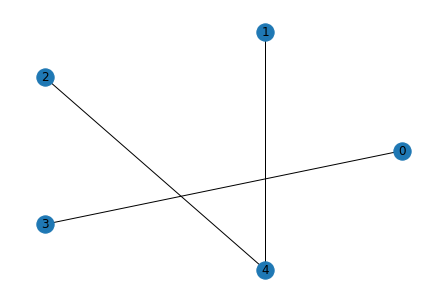

In [25]:
import networkx as nx 
nx.draw(myNetwork.Graph, pos = nx.circular_layout(myNetwork.Graph),with_labels=True)

The edges:

In [26]:
myNetwork.Graph.edges()

EdgeView([(0, 3), (1, 4), (2, 4)])

To save the network and the preference inforamtion:

In [27]:
myNetwork.writeHistory("Data")

## D. EpiCondition

**Please note that DTCNS package is under active development. EpiCondition module will soon be public.**

## E. Process

We assume an epidemic spread on the simulated social network from the seed node 0. 

+ **Process** simulates the dynamic process on social networks. It is initialised with the node number **numNodes**, a set of seed nodes **infectedSet**, an infection rate **infectionRate** and a recovery rate **recoveryRate**.

In [28]:
epiProcess = Process(numNodes=5,
                     infectedSet={0},
                     infectionRate=0.2,
                     recoveryRate=0.2
                    )

We set a random seed 112 and allow the process to propagate one step.

In [29]:
epiProcess.spread(myNetwork.Graph,
       randomseed = 112,
       spreadStep = 1)

The infected node set after spreading process can be represented as:

In [30]:
epiProcess.infectedSet

{0, 3}

The infected nodes recover given a recovery rate of 0.2.

In [31]:
epiProcess.recover(myNetwork.Graph,
       randomseed = 112,
       recoverStep = 1)

The infected node set after recovery process can be represented as:

In [32]:
epiProcess.infectedSet

{0}

To save the information concernning the epidemic spreading process:

In [33]:
epiProcess.writeHistory(saveDir="Data",recoveryRecord=True,spreadRecord=True)

## References

<div id="refer-anchor-1"></div>
- [1] Wen, Jiaqi, Bogdan Gabrys, and Katarzyna Musial. "Digital Twin-Oriented Complex Networked Systems based on Heterogeneous node features and interaction rules." arXiv preprint arXiv:2308.11034 (2023).

<div id="refer-anchor-2"></div>
- [2] Wen, Jiaqi, Bogdan Gabrys, and Katarzyna Musial. "Review and Assessment of Digital Twin--Oriented Social Network Simulators." arXiv preprint arXiv:2308.11034 (2023).